<a href="https://colab.research.google.com/github/alanzhu07/MotionFingerprint/blob/master/Motion_Fingerprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi team!

> This is our main sandbox of code where we can try out stuff quickly and share it fast with the project group. We can move fast and break things here - create a section for your sandbox's bit and build on top of others work. We'll also make a Git later


##Packages Import Section
Import all packages used (visualisation, ML, etc)

This image shows the coordinate system definition we use to process and understand the data
> ![alt text](https://drive.google.com/uc?export=view&id=1ImA9hGKOexy6tPDCeV2lo2T64pMx4KoR)
> ![alt text](https://www.researchgate.net/profile/Anton_Umek/publication/306311098/figure/fig1/AS:396908829921280@1471641847017/Smartphone-with-the-definitions-of-the-local-coordinate-system-and-gyroscope-rotation.png)

Phone is
- pointing down
- screen facing leg

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Flight_dynamics_with_text_ortho.svg/220px-Flight_dynamics_with_text_ortho.svg.png)


Then
- rotation of leg = roll 
- flexion of leg = pitch
- maybe:(adduction of leg = azimuth)


![alt text](https://i.pinimg.com/564x/df/2e/80/df2e8055c4e4d20fd42d615805ce6321.jpg)

In [ ]:
# Installing Packages
!pip install sensormotion # Python package for analyzing sensor-collected human motion data (e.g. physical activity levels, gait dynamics) https://github.com/sho-87/sensormotion 

  Created wheel for sensormotion: filename=sensormotion-1.1.4-cp36-none-any.whl size=19675 sha256=0d3059f2afd34f8a264c0553e2b421bc94072a762e91e33600ee8a58db754c3b
  Stored in directory: /root/.cache/pip/wheels/37/fd/45/ab09232b95205e7fbacf21d60e3472e5b53a1adeee9c1d7711
Successfully built sensormotion


In [ ]:
# Importing Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sensormotion as sm

# Data Importing, Cleaning, and Preparation
Importing and cleaning data from the sensor recording apps (Android, iOS, smartwatches), and prepare the data for ML

First let's connect to the Data Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# RAW Data Input Path
path = '/content/drive/My Drive/Motion_Fingerprint/Data/' + 'phone_datasets/'                 # path to all subjects datasets

# Processed Data Output Path
processed_path = '/content/drive/My Drive/Motion_Fingerprint/Data/phone_datasets_processed/'  # path where to export processed data

## **Import and Clean Android Data**
**Manually switch between subjects**

From the iOS or Andoid app format, for each subject we can run the following functions to import which will create a dataframe from all separate data CSVs of all that subject's data.

In [ ]:
# Get a list of the subjects
import os
subjects_list = set(os.listdir(path + 'Android/')) - set('readme.txt')
subjects_list

{'Alan_Zhu', 'Sergiu_Iliev'}

In [ ]:
set(os.listdir(path + 'Android/Sergiu_Iliev/'))

{'2020-11-10_11-15-06', 'BAD_DATA'}

In [ ]:
dataset_framerate = 100           # frequency of data in Hz
subject_name = 'Sergiu_Iliev/'
folder_names = ['2020-11-10_11-15-06']

# subject_name = 'Alan_Zhu/'
# folder_names = ['2020-10-19_17-23-40', '2020-10-25_18-27-03', '2020-10-25_18-40-54']

### Combine all separate sensor channel CSVs into a single merged one for each data session and subject

In [ ]:
file_names = ['Accelerometer.csv', 'Compass.csv', 'Gravity.csv', 'Gyroscope.csv']

df_merged = pd.DataFrame()                                         # initialize a DataFrame to store all data for this subject

for folder_name in folder_names:
  df = pd.read_csv(str(path + 'Android/' + subject_name + folder_name + '/' + file_names[0]), error_bad_lines=False)
  for i in range(len(file_names)-1):
    df2 = pd.read_csv(str(path + 'Android/' + subject_name + folder_name + '/' + file_names[i+1]), error_bad_lines=False)
    df = df.join(df2.iloc[:, 2:], rsuffix = '_' + file_names[i+1][:-4])
  df.columns = ['Timestamp', 'ms', 'xAcc', 'yAcc', 'zAcc', 'xComp', 'yComp', 'zComp',
                'xGrav', 'yGrav', 'zGrav', 'xGyro', 'yGyro', 'zGyro']
  print(df.tail())

  # Keep the relevant sensor streams and rename the columns in the global format
  df = df[['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro']]      # dropping all other columns  including the time column since we are only interested in frame rate (assuming constant timesteps)
  df.columns = ['ax', 'ay', 'az', 'wx', 'wy', 'wz']                 # keeping only the accelerations and rotations    

  # Save them to the processed folder 
  df.to_csv(str(processed_path + 'Android/' + subject_name + folder_name[:-1] + '.csv'), index = False)

  df_merged = df_merged.append(df, ignore_index=True)

                Timestamp     ms      xAcc  ...     xGyro     yGyro     zGyro
3863  2020-11-10 11:15:44  38631  0.795176  ... -0.424306 -0.087263  0.340922
3864  2020-11-10 11:15:44  38643  0.922063  ... -0.382768 -0.108032  0.316487
3865  2020-11-10 11:15:44  38651  0.878969  ... -0.261816 -0.163010  0.245627
3866  2020-11-10 11:15:44  38661  0.797570  ... -0.201952 -0.174006  0.207753
3867  2020-11-10 11:15:44  38671  0.797570  ... -0.201952 -0.174006  0.207753

[5 rows x 14 columns]


### Visually checking the data to confirm no issues

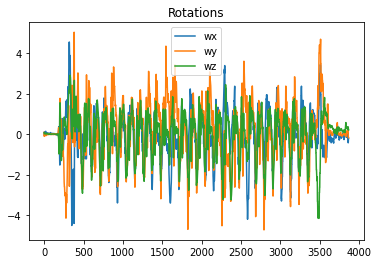

In [ ]:
# Look at how the data appears for a few typical gait cycles
df.iloc[:].plot(y=['wx', 'wy', 'wz'], title='Rotations') # x='frames'

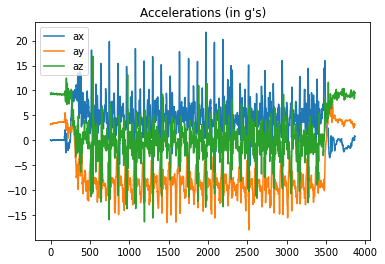

In [ ]:
df.plot(y=['ax', 'ay', 'az'], title='Accelerations (in g\'s)') # x='time'

### View, Clean & Save Android Data
Putting the data into the universal format for a subject (1 dataframe per subject) and saving it back to the drive -- i.e. one dataframe with consistent headings for each subject with all their steps (just of clean steps)

### Visualise data slices

Text(0.5, 0.98, 'G Forces')

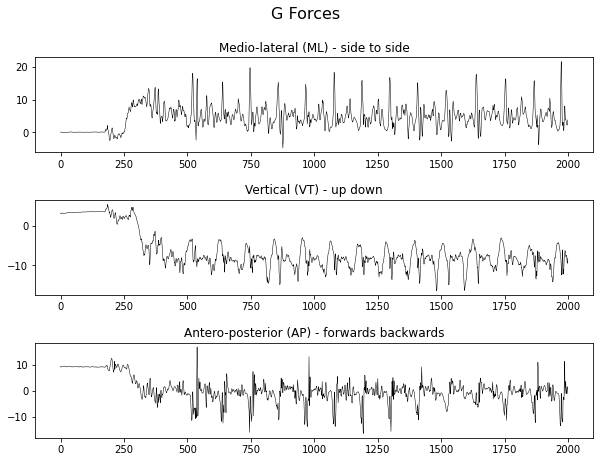

In [ ]:
# We need to check the axes are correct i.e. medio-lateral is actually medio lateral (see first part of this notebook)

# Define what section of the data we want to see (span of the rows to plot)
span = [0, 2000]

# Plot the Acceleration signals on comparative axes
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,7))

timesteps=np.arange(span[0],span[1]) 

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(timesteps, df.ax[span[0]:span[1]], linewidth=0.5, color='k')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(timesteps, df.ay[span[0]:span[1]], linewidth=0.5, color='k')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(timesteps, df.az[span[0]:span[1]], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

fig.suptitle('G Forces', fontsize=16)

Text(0.5, 0.98, 'Rotations')

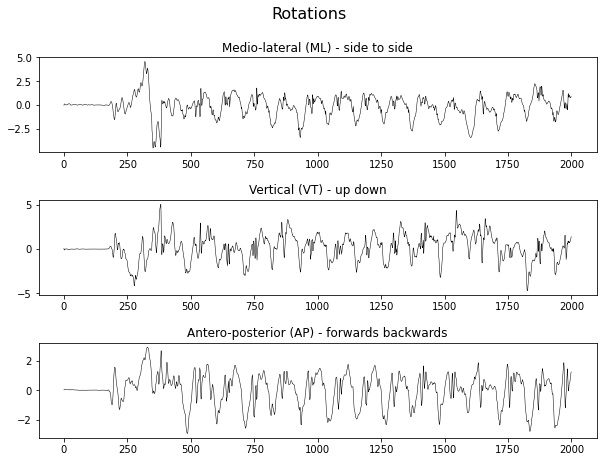

In [ ]:
# Plot the Rotation signals on comparative axes
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,7))

timesteps=np.arange(span[0],span[1]) 

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(timesteps, df.wx[span[0]:span[1]], linewidth=0.5, color='k')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(timesteps, df.wy[span[0]:span[1]], linewidth=0.5, color='k')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(timesteps, df.wz[span[0]:span[1]], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

fig.suptitle('Rotations', fontsize=16)

### Clean the data
We'll find the peaks in the vertical acceleration determine where steps start and stop

In [ ]:
df_merged.shape[0]

3868

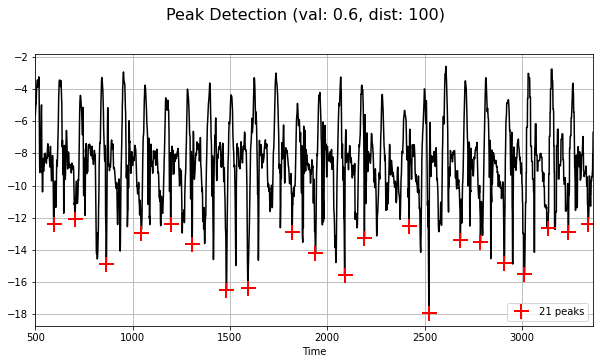

In [ ]:
# change the span to drop the part where subject places the phone in the pocket
span=[5*dataset_framerate,   df_merged.shape[0] - 5*dataset_framerate] # starting at second 5 and ending 5 seconds early to skip the first portion when puttin the phone in the pocket 
timesteps=np.arange(span[0],span[1]) 

# Determine peaks in the vertical acceleration and use this to identify steps
peak_times, peak_values = sm.peak.find_peaks(timesteps, df_merged.ay[span[0]:span[1]], peak_type='valley', min_val=0.6, min_dist=100, plot=True)

In [ ]:
peak_times # these are the indices marking the transitions between steps

array([ 595,  704,  864, 1044, 1196, 1306, 1482, 1592, 1820, 1939, 2089,
       2191, 2421, 2522, 2684, 2787, 2909, 3012, 3134, 3238, 3340])

### Resample

We also divide the gait curve into two-step samples and interpolate them into the same length of 128. As each subject in this dataset has a much larger amount of data as compared to the that in Dataset #1, we do not make overlap between the samples. Finally, a total number of 49,275 samples are collected, in which 44,339 samples are used for training, and the rest 4,936 for test.

To prepare the data, here we create a dictionary that stores each step's frames. For each step, we take 128 frames by resampling from the original frames.

In [ ]:
num_steps = len(peak_times) - 1 
print(num_steps)
step_dict = {}

for i in range(num_steps):
  # find the frames for each step
  df_step = df_merged.loc[peak_times[i]:peak_times[i+1]]

  original_df_step = df_step.copy() ## save original df 

  ## resample the df to approximately 128 frames using datetime
  df_step.index = pd.to_datetime(df_step.index, unit='ms')
  num_frames = peak_times[i+1] - peak_times[i]
  resample_size = int(num_frames * 1000 / 127)
  resample_size_str = str(resample_size) + 'U'
  df_step = df_step.resample(resample_size_str)

  if resample_size >= 1000:
    ## downsample - take mean of multiple values
    df_step = df_step.mean()
  else:
    ## upsample - interpolate to fill NaN
    df_step = df_step.mean().interpolate(method = 'linear')

  ## drop the datetime index, take first 128 rows
  df_step = df_step.reset_index(drop=True)[:128]

  print('step: {}, original size: {}, resampled size: {}'.format(i+1, original_df_step.shape[0], df_step.shape[0]))

  step_dict[i+1] = df_step


20
step: 1, original size: 110, resampled size: 128
step: 2, original size: 161, resampled size: 128
step: 3, original size: 181, resampled size: 128
step: 4, original size: 153, resampled size: 128
step: 5, original size: 111, resampled size: 128
step: 6, original size: 177, resampled size: 128
step: 7, original size: 111, resampled size: 128
step: 8, original size: 229, resampled size: 128
step: 9, original size: 120, resampled size: 128
step: 10, original size: 151, resampled size: 128
step: 11, original size: 103, resampled size: 128
step: 12, original size: 231, resampled size: 128
step: 13, original size: 102, resampled size: 128
step: 14, original size: 163, resampled size: 128
step: 15, original size: 104, resampled size: 128
step: 16, original size: 123, resampled size: 128
step: 17, original size: 104, resampled size: 128
step: 18, original size: 123, resampled size: 128
step: 19, original size: 105, resampled size: 128
step: 20, original size: 103, resampled size: 128
{1:   

Now we convert our data to a dataframe with each row being one step.

In [ ]:
step_arr = np.zeros((num_steps, 128 * 6))
for step in step_dict:
  step_arr[step-1] = step_dict[step].to_numpy().reshape(1, -1)
df_final = pd.DataFrame(step_arr)
print(df_final.shape)

(20, 768)


In [ ]:
df_final.head()

### Save the output

In [ ]:
# Save the subject data to the processed folder 
df_final.to_csv(str(processed_path + subject_name[:-1] + '.csv'), index=False, header=False)

## **Import and Clean iOS Data**

Read all data from folder and combine them with Pandas

In [ ]:
ios_dataset_framerate = 60 # frequency of data in Hz

In [ ]:
import os
subject_name = 'Jack_Chang/'
file_names = [f for f in os.listdir(str(path + 'iOS/' + subject_name)) if f.endswith('.csv')]
df = pd.read_csv(str(path + 'iOS/' + subject_name + file_names[0]), error_bad_lines=False)

print('Dataframe sizes:')
for f in file_names[1:]:
  df_append = pd.read_csv(str(path + 'iOS/' + subject_name + f), error_bad_lines=False)
  df = df.append(df_append, ignore_index=True)
  print(df.shape)
df.tail()

Dataframe sizes:
(1523, 10)
(2084, 10)
(2744, 10)
(3321, 10)
(4150, 10)


,SamplingTime,AccelerationX,AccelerationY,AccelerationZ,GyroX,GyroY,GyroZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ
4145,1.603796e+09,-0.563834,-0.635212,-9.611523,-0.016442,0.121235,0.019153,-6.313553,88.820648,-217.063873
4146,1.603796e+09,-0.686088,-0.402675,-9.419687,-0.016484,-0.076110,-0.029199,-5.655106,88.771057,-216.812515
4147,1.603796e+09,-0.508469,-1.005864,-9.578602,-0.189956,0.099668,-0.040831,-5.593719,88.357788,-216.927170
4148,1.603796e+09,,,,,,,,,
4149,1.603796e+09,,,,,,,,,


In [ ]:
# Keep the relevant sensor streams and rename the columns in the global format
df.columns = ['time', 'ax', 'ay', 'az', 'GyroX', 'GyroY', 'GyroZ', 'Bx', 'By', 'Bz']
df = df[['ax', 'ay', 'az', 'GyroX', 'GyroY', 'GyroZ']]  # dropping all other colums apart from rotation and acceleration including the time column since we are only interested in frame rate (assuming constant timesteps)
df.columns = ['ax', 'ay', 'az', 'wx', 'wy', 'wz']       # renaming to the universal format 
df.tail()
df_merged = df

### View, Clean & Save iOS Data
Putting the data into the universal format for a subject (1 dataframe per subject) and saving it back to the drive -- i.e. one dataframe with consistent headings for each subject with all their steps (just of clean steps)

In [ ]:
# change the span to drop the part where subject places the phone in the pocket
span=[5*ios_dataset_framerate,   df_merged.shape[0] - 5*ios_dataset_framerate] # starting at second 5 and ending 5 seconds early to skip the first portion when puttin the phone in the pocket 
timesteps=np.arange(span[0],span[1]) 

# Determine peaks in the vertical acceleration and use this to identify steps
peak_times, peak_values = sm.peak.find_peaks(timesteps, df_merged.ay[span[0]:span[1]], peak_type='valley', min_val=0.6, min_dist=100, plot=True)

### Clean the data
We'll find the peaks in the vertical acceleration determine where steps start and stop (see Android part)

### Save the output

In [ ]:
df_merged.to_csv(str(processed_path + 'iOS/' + subject_name[:-1] + '.csv'), index = False)

# ML Analysis - Gait Extraction


## **CNN**

In [ ]:
collab_path = '/content/drive/MyDrive/Motion_Fingerprint/Data/phone_datasets_processed/'

In [ ]:
file_names = [f for f in os.listdir(collab_path) if f.endswith('.csv')]
df=pd.DataFrame()
for f in file_names:
  temp_df = pd.read_csv(str(collab_path + f), error_bad_lines=False, header=None)
  temp_df['label']=f.split('.')[0]
  df=pd.concat([df, temp_df], ignore_index=True)

In [ ]:
df.loc[df['label']=='Jack_chang (1)', 'label']='Jack_chang'

In [ ]:
classes_dict=dict(zip(list(df['label'].unique()), range(len(df['label'].unique()))))

In [ ]:
from keras.utils import to_categorical
y=to_categorical(df['label'].map(classes_dict))

In [ ]:
X=df.loc[:, df.columns != 'label']
X=np.array(X[:])

In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy=train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train=trainX.reshape(trainX.shape[0], trainX.shape[1], 1)

X_test=testX.reshape(testX.shape[0], testX.shape[1], 1)

In [ ]:
batch_size=10
num_classes=3
epochs=15
input_shape=(X_train.shape[1], 1)

In [ ]:
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

In [ ]:
model=Sequential()

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))

model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(64, activation='tanh'))

model.add(Dropout(0.2))

model.add(Dense(32, activation='tanh'))

model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

model.summary()


In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(X_train, trainy, epochs=epochs, batch_size=batch_size)

In [ ]:
model.evaluate(X_test, testy, batch_size=batch_size)